## 🏕️ Phần 1: Giới thiệu – Đặt vấn đề

Nhận dạng lá cây là một bài toán quan trọng trong lĩnh vực **thị giác máy tính** và **trí tuệ nhân tạo**.  
Mục tiêu của đề tài là **xây dựng mô hình mạng nơ-ron nhân tạo (ANN)** có khả năng **phân loại các loại lá cây khác nhau** dựa trên hình ảnh đầu vào.  

Mô hình sẽ được huấn luyện từ tập ảnh lá cây, trải qua các bước:
- **Tiền xử lý ảnh** và **trích đặc trưng Hu Moments**.  
- **Chuẩn hóa dữ liệu** và **huấn luyện mạng ANN**.  
- **Đánh giá độ chính xác** trên tập kiểm tra.

Kết quả mong đợi là mô hình ANN có thể **nhận dạng chính xác loại lá cây** dựa vào hình dạng và đặc trưng của lá.


## 🧩 Phần 2: Phương pháp thực hiện  
### 🔹 Bước 1: Chuẩn bị dữ liệu  

Trong bước này, tiến hành xây dựng và mở rộng tập dữ liệu ảnh lá cây dùng cho mô hình huấn luyện.

- **Nguồn dữ liệu:** sử dụng cơ sở dữ liệu lá cây tự xây dựng, đảm bảo mỗi lớp (class) thể hiện một loại lá khác nhau.  
- **Data Augmentation:** từ mỗi ảnh gốc, tạo thêm 4 ảnh bằng cách **xoay quanh centroid** với các góc:  
  `+7°, -7°, +15°, -15°`.  
  → Mỗi class có 10 ảnh gốc + 40 ảnh mở rộng = **50 ảnh**.  

- **Đặt ID cho ảnh** theo thứ tự:  
  - Class 1: 1 – 50  
  - Class 2: 51 – 100  
  - Class 3: 101 – 150  
  - Class 4: 151 – 200  
  - Class 5: 201 – 250  

- **Phân chia dữ liệu trong mỗi class** thành 3 folder ngẫu nhiên:  
  - Folder 1: 35 mẫu (train)  
  - Folder 2: 8 mẫu (validation)  
  - Folder 3: 7 mẫu (test)  

Ảnh trong mỗi folder được chọn **ngẫu nhiên** để đảm bảo tính khách quan.  
Một vài ảnh đại diện sau khi thực hiện augmentation sẽ được hiển thị để quan sát và nhận xét.


In [1]:
#  Bước 1: Chuẩn bị dữ liệu
# Thực hiện Data Augmentation cho tập ảnh lá cây

import os
import cv2
import numpy as np
import random
import shutil

# --- Cấu hình ---
input_root = "/media/pphong/D:/ML & DL/ML/ANN/dataset_leafs"            # Thư mục ảnh gốc
output_root = "/media/pphong/D:/ML & DL/ML/ANN/dataset_augmented"       # Thư mục lưu kết quả
angles = [7, -7, 15, -15]               # Góc xoay augmentation
folders = ["train", "val", "test"]      # Thư mục chia dữ liệu
split_ratio = [35, 8, 7]                # Số lượng mẫu mỗi folder
os.makedirs(output_root, exist_ok=True)

# --- Hàm xoay ảnh quanh tâm ---
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# --- Duyệt từng class trong dataset gốc ---
current_id = 1
for class_idx, class_name in enumerate(sorted(os.listdir(input_root)), start=1):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"🔹 Xử lý class {class_name} ...")
    class_output = os.path.join(output_root, class_name)
    os.makedirs(class_output, exist_ok=True)

    all_images = []

    for img_file in sorted(os.listdir(class_path)):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Lưu ảnh gốc
        base_name = f"{class_name}_{current_id}.jpg"
        cv2.imwrite(os.path.join(class_output, base_name), img)
        all_images.append(base_name)

        # Augmentation: xoay ảnh
        for angle in angles:
            rotated = rotate_image(img, angle)
            new_name = f"{class_name}_{current_id}_rot{angle}.jpg"
            cv2.imwrite(os.path.join(class_output, new_name), rotated)
            all_images.append(new_name)

        current_id += 1

    # --- Chia folder train/val/test ngẫu nhiên ---
    random.shuffle(all_images)
    train, val, test = np.split(np.array(all_images), [split_ratio[0], split_ratio[0]+split_ratio[1]])

    for folder_name, data_split in zip(folders, [train, val, test]):
        folder_path = os.path.join(class_output, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        for img_name in data_split:
            src = os.path.join(class_output, img_name)
            dst = os.path.join(folder_path, img_name)
            shutil.move(src, dst)

    print(f" Class {class_name} hoàn tất ({len(all_images)} ảnh)\n")

print(" Data augmentation và chia dữ liệu hoàn tất!")


🔹 Xử lý class la_bang ...
 Class la_bang hoàn tất (50 ảnh)

🔹 Xử lý class la_trau ...
 Class la_trau hoàn tất (50 ảnh)

🔹 Xử lý class la_truc ...
 Class la_truc hoàn tất (50 ảnh)

 Data augmentation và chia dữ liệu hoàn tất!


### 🌿 Bước 2: Tiền xử lý dữ liệu  

Mục tiêu của bước này là **nhị phân hóa ảnh** để làm nổi bật vùng chứa lá cây (đối tượng)  
và loại bỏ ảnh nền không cần thiết.  

Yêu cầu:
- **Vùng lá cây:** màu trắng (giá trị 1 hoặc 255)  
- **Vùng nền:** màu đen (giá trị 0)  

Các bước thực hiện:
1. Đọc ảnh màu gốc.  
2. Chuyển sang ảnh xám (grayscale).  
3. Áp dụng thuật toán **Otsu thresholding** để nhị phân hóa.  
4. Đảm bảo lá là vùng trắng, nền là vùng đen (đảo nếu cần).  
5. Hiển thị kết quả ảnh gốc → ảnh xám → ảnh nhị phân và lưu kết quả ra thư mục mới.


 Đang xử lý lớp: la_bang
 Đang xử lý lớp: la_trau
 Đang xử lý lớp: la_truc
 Đã chuyển toàn bộ dataset sang ảnh nhị phân (lá trắng, nền đen)


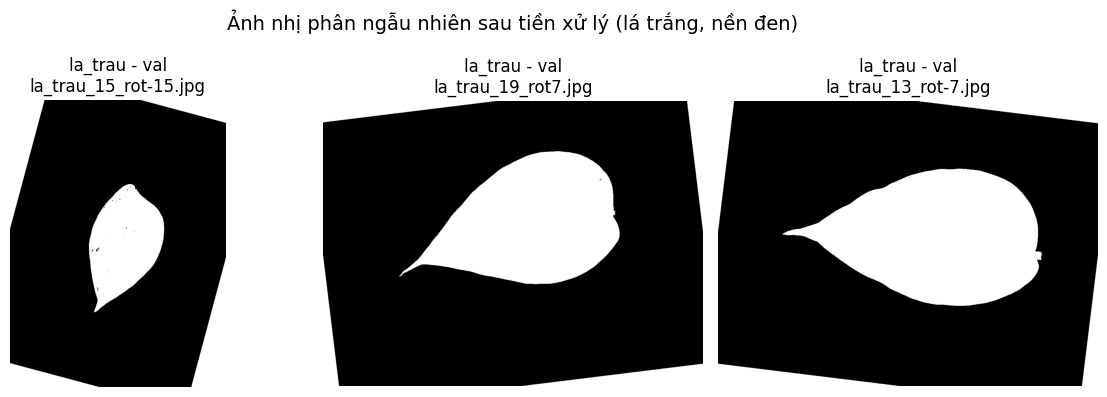

In [7]:
# 🌿 Bước 2: Tiền xử lý dữ liệu - Chuyển ảnh sang nhị phân (lá trắng, nền đen)
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Thư mục đầu vào & đầu ra ---
input_root = "dataset_augmented"   # Thư mục chứa ảnh màu đã augment và chia train/val/test
output_root = "dataset_binary"     # Thư mục lưu ảnh nhị phân
os.makedirs(output_root, exist_ok=True)

# --- Xử lý toàn bộ dataset ---
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f" Đang xử lý lớp: {class_name}")

    for subset in ["train", "val", "test"]:
        input_folder = os.path.join(class_path, subset)
        output_folder = os.path.join(output_root, class_name, subset)
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(input_folder):
            continue

        for file in os.listdir(input_folder):
            if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            # Đọc ảnh và chuyển sang grayscale
            img_path = os.path.join(input_folder, file)
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Nhị phân hóa bằng Otsu threshold
            _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Đảm bảo lá cây màu trắng, nền đen
            white_ratio = np.mean(binary == 255)
            if white_ratio > 0.5:  # nếu vùng trắng ít hơn → lá đang đen, nền trắng → đảo lại
                binary = cv2.bitwise_not(binary)

            # Lưu ảnh nhị phân
            save_path = os.path.join(output_folder, file)
            cv2.imwrite(save_path, binary)

print(" Đã chuyển toàn bộ dataset sang ảnh nhị phân (lá trắng, nền đen)")

# --- Hiển thị ngẫu nhiên một vài ảnh sau khi tiền xử lý ---
random_class = random.choice(os.listdir(output_root))
random_subset = random.choice(["train", "val", "test"])
folder_path = os.path.join(output_root, random_class, random_subset)

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
sample_images = random.sample(image_files, min(3, len(image_files)))

plt.figure(figsize=(12, 4))
for idx, file in enumerate(sample_images):
    img_path = os.path.join(folder_path, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(1, 3, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{random_class} - {random_subset}\n{file}")
    plt.axis("off")

plt.suptitle("Ảnh nhị phân ngẫu nhiên sau tiền xử lý (lá trắng, nền đen)", fontsize=14)
plt.tight_layout()
plt.show()


### 🌿 Bước 3: Trích đặc trưng  

Trong bước này, tiến hành **tính toán đặc trưng Hu Moments** cho từng ảnh nhị phân.  
Đây là bộ đặc trưng mô tả **hình dạng tổng quát của vật thể**, không phụ thuộc vào vị trí, kích thước hay góc quay của ảnh.

Các bước thực hiện:
1. **Tính 7 đặc trưng Hu Moments** cho mỗi ảnh.  
2. **Lấy logarit theo công thức** để giữ nguyên dấu của giá trị gốc và tránh lỗi log(0):  

   $$
   Hu' = -sign(Hu) \times \log_{10}(|Hu| + 1e-10)
   $$

3. **Chuẩn hóa đặc trưng** về khoảng [0, 1].  
4. **Trực quan hóa đặc trưng:** vẽ đồ thị phân tán (scatter plot) của 2 đặc trưng đầu tiên, mỗi class có một màu riêng.  
5. **Nhận xét:** các lớp có thể được tách biệt phần nào dựa vào hình dạng lá.


 Đã trích xuất 150 mẫu với 7 đặc trưng Hu Moments



,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7,label
0,0.459239,0.489025,0.964561,0.697592,1.000000e+00,0.999870,1.000000e+00,la_bang
1,0.809627,0.556757,0.772790,0.816314,1.000000e+00,0.999920,1.842970e-12,la_bang
2,0.245917,0.313012,0.975753,0.920014,7.084888e-13,0.000023,1.000000e+00,la_bang
3,0.191767,0.315813,0.939449,0.820563,1.270439e-11,0.000133,1.000000e+00,la_bang
4,0.191645,0.236328,0.873571,0.781676,1.000000e+00,0.999829,2.897027e-11,la_bang


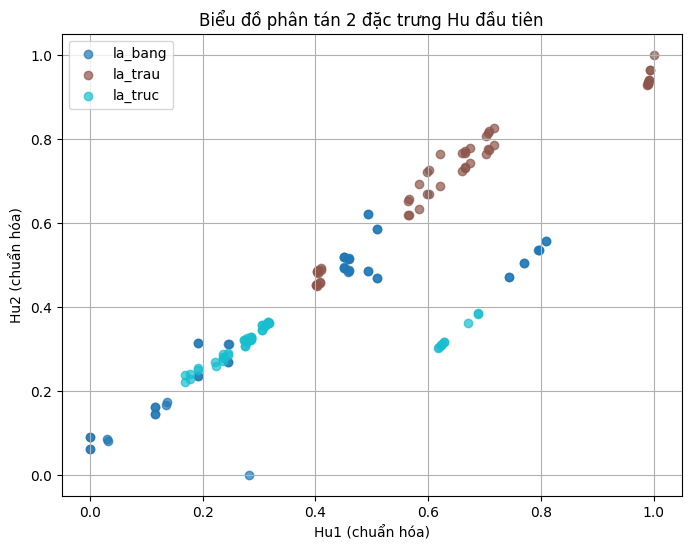

In [8]:
# 🌿 Bước 3: Trích đặc trưng Hu Moments và trực quan hóa
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# --- Thư mục dữ liệu nhị phân ---
input_root = "dataset_binary"

# --- Hàm tính Hu Moments ---
def extract_hu_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Tính moment và Hu Moments
    moments = cv2.moments(img)
    huMoments = cv2.HuMoments(moments).flatten()

    # Log-transform giữ nguyên dấu
    huMoments_log = -np.sign(huMoments) * np.log10(np.abs(huMoments) + 1e-10)
    return huMoments_log

# --- Lưu tất cả đặc trưng ---
features = []
labels = []

for class_name in sorted(os.listdir(input_root)):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    for subset in ["train", "val", "test"]:
        subset_path = os.path.join(class_path, subset)
        if not os.path.exists(subset_path):
            continue

        for file in os.listdir(subset_path):
            if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            img_path = os.path.join(subset_path, file)
            hu = extract_hu_features(img_path)
            if hu is not None:
                features.append(hu)
                labels.append(class_name)

# --- Chuyển sang DataFrame ---
features = np.array(features)
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)

df = pd.DataFrame(features_norm, columns=[f'Hu{i+1}' for i in range(7)])
df['label'] = labels

print(f" Đã trích xuất {len(df)} mẫu với 7 đặc trưng Hu Moments\n")
display(df.head())

# --- Trực quan hóa 2 đặc trưng đầu tiên ---
plt.figure(figsize=(8,6))
unique_classes = df['label'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

for cls, color in zip(unique_classes, colors):
    subset = df[df['label'] == cls]
    plt.scatter(subset['Hu1'], subset['Hu2'], color=color, label=cls, alpha=0.7)

plt.title("Biểu đồ phân tán 2 đặc trưng Hu đầu tiên")
plt.xlabel("Hu1 (chuẩn hóa)")
plt.ylabel("Hu2 (chuẩn hóa)")
plt.legend()
plt.grid(True)
plt.show()


### 🔍 Nhận xét

Từ bảng dữ liệu và biểu đồ phân tán (Hu1 – Hu2) có thể rút ra một số nhận xét như sau:

- Các điểm dữ liệu của từng **class lá cây** (la_bang, la_trau, la_truc) có xu hướng **tập trung thành cụm riêng biệt**.
- Đặc trưng Hu Moments thể hiện khá tốt **hình dạng tổng thể của lá**, do đó giúp **phân biệt được các loại lá khác nhau**.
- Một số vùng có thể **xảy ra chồng lấn nhẹ** giữa các lớp, điều này là bình thường vì đặc trưng Hu chỉ mô tả hình dạng, chưa xét đến yếu tố chi tiết hoặc kết cấu bề mặt.
- Sau khi **chuẩn hóa về [0,1]**, giá trị Hu1 và Hu2 đều nằm trong khoảng hợp lý, đảm bảo đầu vào cho mô hình ANN ổn định.
- Nhìn chung, kết quả này cho thấy **đặc trưng Hu Moments phù hợp để dùng huấn luyện mô hình nhận dạng lá cây ở bước tiếp theo.**


### 🤖 Bước 4: Huấn luyện mô hình ANN  

Trong bước này, tiến hành xây dựng và huấn luyện mô hình **mạng nơ-ron nhân tạo (ANN)** để phân loại các loại lá cây dựa trên đặc trưng Hu Moments đã trích xuất ở bước trước.

**Cấu hình mô hình:**
- Lớp input: 7 nơ-ron (tương ứng 7 đặc trưng Hu).  
- Lớp ẩn: 1 lớp ẩn với số nơ-ron thay đổi lần lượt là 7, 8, 9, 10 (chọn mô hình tốt nhất).  
- Lớp đầu ra: số nơ-ron = số lớp (class).  
- Mã hóa đầu ra: *One-hot encoding.*  
- Hàm kích hoạt lớp ẩn: **Sigmoid**  
- Hàm kích hoạt lớp ra: **Softmax**  
- Hàm mất mát: **Categorical Cross-Entropy (CCE)**  
- Thuật toán tối ưu: **Batch Gradient Descent (BGD)**  
- Tốc độ học: η = 0.1  
- Số epoch: 200  
- Khởi tạo trọng số ngẫu nhiên.  

Sau khi huấn luyện, ta quan sát đồ thị **loss của training và validation** qua từng epoch để đánh giá độ hội tụ của mô hình.


In [ ]:
# 🤖 Bước 4: Huấn luyện mô hình ANN
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- Chuẩn bị dữ liệu ---
X = df.iloc[:, 0:7].values
y = df['label'].values

# Mã hóa nhãn thành số
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Chia dữ liệu train/val
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

# --- Hàm huấn luyện mô hình với số neuron ẩn tùy chọn ---
def train_ann(hidden_neurons):
    model = Sequential([
        Dense(hidden_neurons, input_dim=7, activation='sigmoid'),
        Dense(y_onehot.shape[1], activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=200, batch_size=len(X_train),
                        verbose=0)
    return model, history

# --- Huấn luyện với 4 cấu hình khác nhau ---
hidden_options = [7, 8, 9, 10]
histories = {}
for n in hidden_options:
    print(f"🔹 Đang huấn luyện mô hình với {n} neuron ẩn...")
    model, history = train_ann(n)
    histories[n] = history

# --- Vẽ đồ thị loss ---
plt.figure(figsize=(10,6))
for n, history in histories.items():
    plt.plot(history.history['loss'], label=f'Train loss ({n} hidden)')
plt.title("Training loss theo số neuron ẩn")
plt.xlabel("Epoch")
plt.ylabel("Loss (CCE)")
plt.legend()
plt.grid(True)
plt.show()

# --- Vẽ đồ thị validation loss ---
plt.figure(figsize=(10,6))
for n, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'Val loss ({n} hidden)')
plt.title("Validation loss theo số neuron ẩn")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (CCE)")
plt.legend()
plt.grid(True)
plt.show()

# --- Đánh giá mô hình tốt nhất ---
best_n = min(hidden_options, key=lambda n: histories[n].history['val_loss'][-1])
best_val_loss = histories[best_n].history['val_loss'][-1]
best_acc = histories[best_n].history['val_accuracy'][-1]

print(f"\n Mô hình tốt nhất: {best_n} neuron ẩn")
print(f"Validation loss: {best_val_loss:.4f}")
print(f"Validation accuracy: {best_acc*100:.2f}%")
